In [1]:
from typing import TypedDict,Annotated
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
# for tool nodes
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition 

In [2]:
class State(TypedDict):
    messages: Annotated[list,add_messages]


In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

c:\Users\vansh\OneDrive\Desktop\Agentic-AI-using-LangGraph\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Chatbot With Tool

In [5]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)
tool.invoke("What is latest news about AI?")

{'query': 'What is latest news about AI?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'AI News & Artificial Intelligence | TechCrunch',
   'url': 'https://techcrunch.com/category/artificial-intelligence/',
   'content': 'Read the latest on artificial intelligence and machine learning tech, the companies that are building them, and the ethical issues AI raises today.',
   'score': 0.67243975,
   'raw_content': None},
  {'title': 'Artificial Intelligence News -- ScienceDaily',
   'url': 'https://www.sciencedaily.com/news/computers_math/artificial_intelligence/',
   'content': 'Artificial Intelligence News. Everything on AI including futuristic robots with artificial intelligence, computer models of human intelligence and more.',
   'score': 0.6530611,
   'raw_content': None}],
 'response_time': 1.59}

In [6]:
def multiply(a: int, b: int) -> int:
    """Multiplies two integers.
    
    args:
        a (int): The first integer.
        b (int): The second integer.
    returns:
        int: The product of the two integers.
        
    """
    return a * b

In [7]:
tools = [tool, multiply]

In [8]:
llm_with_tool=llm.bind_tools(tools)

In [9]:

def tool_calling_llm(state: State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

builder = StateGraph(State)

builder.add_node("tool_calling_llm",tool_calling_llm,)
builder.add_node("tools", ToolNode(tools)) 

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", END)

graph = builder.compile()

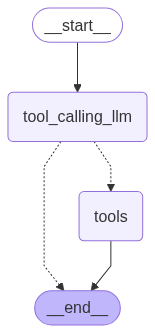

In [10]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
response = graph.invoke({"messages": ["hey what is the latest AI news?"]})


The prompt given below shows if we do tool call with multiple task min it it will take limited amount of task and as per our structure of graph it will end with out completing whole prompt so we have to solve this problem 

In [21]:
response = graph.invoke({"messages": ["What is 2 * 3? then search for latest AI newsnd then multiply ans of first question with 0.5"]})
for m in response["messages"]:
    m.pretty_print()
    

================================ Human Message =================================

What is 2 * 3? then search for latest AI newsnd then multiply ans of first question with 0.5
================================== Ai Message ==================================
Tool Calls:
  multiply (b0c9b9c8-8bf2-4de5-9009-3261811198ee)
 Call ID: b0c9b9c8-8bf2-4de5-9009-3261811198ee
  Args:
    a: 2.0
    b: 3.0
  tavily_search (2bb1941e-9095-491a-97c5-e8a9698f19f0)
 Call ID: 2bb1941e-9095-491a-97c5-e8a9698f19f0
  Args:
    query: latest AI news
    topic: general
================================= Tool Message =================================
Name: multiply

6
================================= Tool Message =================================
Name: tavily_search

{"query": "latest AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "AI News | Latest AI News, Analysis & Events", "url": "https://www.artificialintelligence-news.com/", "content": "AI News reports on the lat

ReAct Agent Architecture

In [23]:
def tool_calling_llm(state: State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

builder = StateGraph(State)

builder.add_node("tool_calling_llm",tool_calling_llm,)
builder.add_node("tools", ToolNode(tools)) 

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", "tool_calling_llm")

graph = builder.compile()

now this is the solution every time tool give output it will check by llm that whole prompt is answerd or not so by this way we can solve previous problem using ReAct Agents 

ReAct => Act -> observe -> reason

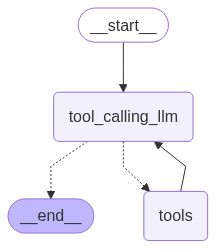

In [24]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
response = graph.invoke({"messages": ["What is 2 * 3? then search for latest AI newsnd then multiply ans of first question with 0.5"]})
for m in response["messages"]:
    m.pretty_print()
    

================================ Human Message =================================

What is 2 * 3? then search for latest AI newsnd then multiply ans of first question with 0.5
================================== Ai Message ==================================
Tool Calls:
  multiply (002d6cc1-a17d-48ae-b1f4-9f0be9fada41)
 Call ID: 002d6cc1-a17d-48ae-b1f4-9f0be9fada41
  Args:
    a: 2.0
    b: 3.0
  tavily_search (a60bd65e-60b9-4662-943e-6acb5bf0af9c)
 Call ID: a60bd65e-60b9-4662-943e-6acb5bf0af9c
  Args:
    query: latest AI news
    topic: general
================================= Tool Message =================================
Name: multiply

6
================================= Tool Message =================================
Name: tavily_search

{"query": "latest AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "AI News | Latest AI News, Analysis & Events", "url": "https://www.artificialintelligence-news.com/", "content": "AI News reports on the lat